##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API - read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [1]:
!pip install -Uq google-generativeai

In [2]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [3]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

Install the PDF processing tools:

In [4]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (332 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...


## Download and proces the PDF

This textbook is from OpenStax, it's License is Commons Attribution License v4.0. More detrails are [available on the site](https://openstax.org/details/books/university-physics-volume-2).

In [5]:
import pathlib

In [6]:
!curl -o test.pdf https://assets.openstax.org/oscms-prodcms/media/documents/UniversityPhysicsVolume2-WEB_5eNhMSa.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59.2M  100 59.2M    0     0   154M      0 --:--:-- --:--:-- --:--:--  154M


You'll extract Chapter 3, pages [121-154].

In [9]:
first = 121
last = 154

In [10]:
!mkdir output
! # extract images of Chapter 3
!pdftoppm test.pdf -f {first} -l {last} output/images -jpeg
!ls output

images-121.jpg	images-127.jpg	images-133.jpg	images-139.jpg	images-145.jpg	images-151.jpg
images-122.jpg	images-128.jpg	images-134.jpg	images-140.jpg	images-146.jpg	images-152.jpg
images-123.jpg	images-129.jpg	images-135.jpg	images-141.jpg	images-147.jpg	images-153.jpg
images-124.jpg	images-130.jpg	images-136.jpg	images-142.jpg	images-148.jpg	images-154.jpg
images-125.jpg	images-131.jpg	images-137.jpg	images-143.jpg	images-149.jpg
images-126.jpg	images-132.jpg	images-138.jpg	images-144.jpg	images-150.jpg


Look at the first image, scaled down:

In [11]:
import PIL.Image

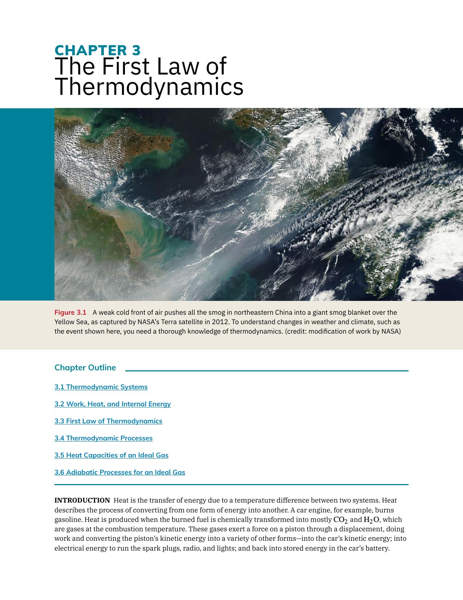

In [12]:
img = PIL.Image.open(f"output/images-{first}.jpg")
img.thumbnail([600, 600])
img

Extract the text for thopse same pages.

In [13]:
for page_number in range(first,last+1):
  page_number = f"{page_number:03d}"
  ! pdftotext  test.pdf -f {page_number} -l {page_number}
  ! mv test.txt output/text-{page_number}.txt

In [14]:
!ls output

images-121.jpg	images-133.jpg	images-145.jpg	text-123.txt  text-135.txt  text-147.txt
images-122.jpg	images-134.jpg	images-146.jpg	text-124.txt  text-136.txt  text-148.txt
images-123.jpg	images-135.jpg	images-147.jpg	text-125.txt  text-137.txt  text-149.txt
images-124.jpg	images-136.jpg	images-148.jpg	text-126.txt  text-138.txt  text-150.txt
images-125.jpg	images-137.jpg	images-149.jpg	text-127.txt  text-139.txt  text-151.txt
images-126.jpg	images-138.jpg	images-150.jpg	text-128.txt  text-140.txt  text-152.txt
images-127.jpg	images-139.jpg	images-151.jpg	text-129.txt  text-141.txt  text-153.txt
images-128.jpg	images-140.jpg	images-152.jpg	text-130.txt  text-142.txt  text-154.txt
images-129.jpg	images-141.jpg	images-153.jpg	text-131.txt  text-143.txt
images-130.jpg	images-142.jpg	images-154.jpg	text-132.txt  text-144.txt
images-131.jpg	images-143.jpg	text-121.txt	text-133.txt  text-145.txt
images-132.jpg	images-144.jpg	text-122.txt	text-134.txt  text-146.txt


In [15]:
!cat output/text-{first}.txt

CHAPTER 3

The First Law of
Thermodynamics

Figure 3.1 A weak cold front of air pushes all the smog in northeastern China into a giant smog blanket over the
Yellow Sea, as captured by NASA’s Terra satellite in 2012. To understand changes in weather and climate, such as
the event shown here, you need a thorough knowledge of thermodynamics. (credit: modification of work by NASA)

Chapter Outline
3.1 Thermodynamic Systems
3.2 Work, Heat, and Internal Energy
3.3 First Law of Thermodynamics
3.4 Thermodynamic Processes
3.5 Heat Capacities of an Ideal Gas
3.6 Adiabatic Processes for an Ideal Gas

INTRODUCTION Heat is the transfer of energy due to a temperature difference between two systems. Heat
describes the process of converting from one form of energy into another. A car engine, for example, burns
gasoline. Heat is produced when the burned fuel is chemically transformed into mostly
and
which
are gases at the combustion temperature. These gases exert a force on a piston through a displacem

## Assemble the files into a prompt

Upload all the files usng the files API, there are too many to send with the `generate_content` request.

In [16]:
files = []
image_files = list(pathlib.Path("output").glob('images-*.jpg'))
for img in tqdm.tqdm(image_files):
    files.append(genai.upload_file(img))

100%|██████████| 34/34 [01:14<00:00,  2.20s/it]


Load all the texts:

In [17]:
texts = [t.read_text() for t in pathlib.Path("output").glob('text-*.txt')]

Interleave the page-numbers, texts, and image-file references:

In [18]:
textbook = []
for page, (text, image) in enumerate(zip(texts, files)):
  textbook.append(f'## Page {first+page} ##')
  textbook.append(text)
  textbook.append(image)

## Try it out

In [19]:
model = genai.GenerativeModel(model_name='gemini-1.5-pro-latest')

In [20]:
response = model.generate_content(
    ['# Here is a chapter from a physics text book:']+
    textbook +
    ["[END]\n\nPlease sumarize it"]
)

In [21]:
from IPython.display import Markdown
Markdown(response.text)

This chapter from a physics textbook delves into the First Law of Thermodynamics, a fundamental concept in understanding energy interactions within systems. It begins by defining key terms like **thermodynamic systems, surroundings, boundaries, thermal equilibrium, and thermodynamic temperature**. The chapter then introduces the concept of **work done by a system**, particularly focusing on the work done by a gas during expansion or compression. It explains how to calculate this work using pressure, volume, and the principles of integration.

The text then differentiates between **heat** and **internal energy**. Internal energy represents the total mechanical energy of all molecules within a system. In contrast, heat refers to the energy transferred between systems or a system and its surroundings due to temperature differences.

The heart of the chapter lies in the **First Law of Thermodynamics**, which posits that the change in internal energy of a system equals the heat added to the system minus the work done by the system. This principle, essentially a reiteration of energy conservation, governs how energy transformations occur within thermodynamic systems.

Further, the chapter classifies thermodynamic processes into several categories, including **isothermal, adiabatic, isobaric, and isochoric processes**. It elaborates on each process type, explaining the constraints and providing mathematical relationships to calculate work, heat, and internal energy changes during these processes. 

The concepts of **specific heat** and **molar heat capacity** are also discussed, highlighting their significance in understanding heat absorption and temperature changes in ideal gases.

The chapter concludes by addressing **adiabatic processes**, particularly for ideal gases. It derives the adiabatic condition equation and illustrates its application in calculating thermodynamic variables during adiabatic expansions or compressions. Overall, this chapter provides a comprehensive overview of the First Law of Thermodynamics and its application in various thermodynamic processes, laying the foundation for further exploration of thermodynamic principles. 
